<a href="https://colab.research.google.com/github/sophia-duran/letterboxd-data-analysis/blob/main/LetterboxdAnalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**🎞️ Sophia Duran’s Letterboxd Lens**

A data-driven dive into six years of movie-watching behavior
From genre binges to globe-spanning tastes, this dashboard captures the rhythms, obsessions, and hidden gems of my film life. Built from Letterboxd logs and enriched with TMDb metadata, it visualizes not just what I watched—but how I felt about it, when I watched it, and who kept showing up in my feed.
Whether it’s tracking favorite directors, mapping film origins, or spotting rating trends over time, this is cinema through a personal lens—equal parts data and emotion.

###🗂️ Setup, Imports, Preview

In [398]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [399]:
import zipfile
import os


zip_path = '/content/drive/MyDrive/LetterboxdData/letterboxd-sophia_duran-2025-06-06-15-42-utc.zip'
extract_path = '/content/drive/MyDrive/LetterboxdData/extracted'


os.makedirs(extract_path, exist_ok=True)


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [400]:
for file in os.listdir(extract_path):
    file_path = os.path.join(extract_path, file)
    try:
        df = pd.read_csv(file_path)
        print(f"{file}: {df.shape[0]} rows, {df.shape[1]} columns")
    except Exception as e:
        print(f"{file}: ⚠️ Could not read ({e})")


profile.csv: 1 rows, 10 columns
watched.csv: 363 rows, 4 columns
ratings.csv: 363 rows, 5 columns
diary.csv: 38 rows, 8 columns
reviews.csv: 34 rows, 9 columns
watchlist.csv: 134 rows, 4 columns
comments.csv: 2 rows, 3 columns
deleted: ⚠️ Could not read ([Errno 21] Is a directory: '/content/drive/MyDrive/LetterboxdData/extracted/deleted')
orphaned: ⚠️ Could not read ([Errno 21] Is a directory: '/content/drive/MyDrive/LetterboxdData/extracted/orphaned')
likes: ⚠️ Could not read ([Errno 21] Is a directory: '/content/drive/MyDrive/LetterboxdData/extracted/likes')
lists: ⚠️ Could not read ([Errno 21] Is a directory: '/content/drive/MyDrive/LetterboxdData/extracted/lists')


In [401]:
diary = pd.read_csv(f'{extract_path}/diary.csv')
ratings = pd.read_csv(f'{extract_path}/ratings.csv')
watchlist = pd.read_csv(f'{extract_path}/watchlist.csv')


In [402]:
diary.head()
diary.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            38 non-null     object 
 1   Name            38 non-null     object 
 2   Year            38 non-null     int64  
 3   Letterboxd URI  38 non-null     object 
 4   Rating          38 non-null     float64
 5   Rewatch         2 non-null      object 
 6   Tags            1 non-null      object 
 7   Watched Date    38 non-null     object 
dtypes: float64(1), int64(1), object(6)
memory usage: 2.5+ KB


In [403]:

diary['Date'] = pd.to_datetime(diary['Date'], errors='coerce')
diary = diary.dropna(subset=['Date'])

diary['Year'] = diary['Date'].dt.year
diary['Month'] = diary['Date'].dt.to_period('M')
diary['Weekday'] = diary['Date'].dt.day_name()
diary['Rewatch'] = diary['Rewatch'].fillna(False)


In [404]:
!pip install requests tqdm


In [405]:
import requests
from tqdm import tqdm
import pandas as pd

tmdb_api_key = '72ba2f3d2334570379e8ce24ae756b93'

def fetch_tmdb_data(title, year=None):
    base_url = 'https://api.themoviedb.org/3'
    search_url = f'{base_url}/search/movie'
    params = {'api_key': tmdb_api_key, 'query': title}
    if year:
        params['year'] = int(year)

    r = requests.get(search_url, params=params)
    results = r.json().get('results')

    if not results:
        return pd.Series([None]*5, index=['tmdb_id', 'genres', 'release_year', 'director', 'runtime'])

    movie = results[0]
    tmdb_id = movie['id']


    details_url = f'{base_url}/movie/{tmdb_id}'
    credits_url = f'{base_url}/movie/{tmdb_id}/credits'

    details = requests.get(details_url, params={'api_key': tmdb_api_key}).json()
    credits = requests.get(credits_url, params={'api_key': tmdb_api_key}).json()

    genres = [g['name'] for g in details.get('genres', [])]
    release_year = details.get('release_date', '')[:4]
    runtime = details.get('runtime', None)

    director = None
    for crew in credits.get('crew', []):
        if crew['job'] == 'Director':
            director = crew['name']
            break

    return pd.Series([tmdb_id, genres, release_year, director, runtime],
                     index=['tmdb_id', 'genres', 'release_year', 'director', 'runtime'])


In [406]:
sample = diary[['Name', 'Year']].drop_duplicates().head(50)
enriched = sample.apply(lambda row: fetch_tmdb_data(row['Name'], row['Year']), axis=1)
sample_enriched = pd.concat([sample.reset_index(drop=True), enriched], axis=1)


In [407]:
sample_enriched.head(10)


,Name,Year,tmdb_id,genres,release_year,director,runtime
0,Mean Girls,2024,10625.0,"[Drama, Comedy]",2004,Mark Waters,97.0
1,Saltburn,2024,930564.0,"[Drama, Comedy, Thriller]",2023,Emerald Fennell,131.0
2,The Idea of You,2024,843527.0,"[Romance, Drama, Comedy]",2024,Michael Showalter,116.0
3,Ocean's Eight,2024,NaN,None,None,None,NaN
4,Challengers,2024,937287.0,"[Drama, Romance]",2024,Luca Guadagnino,132.0
5,Inside Out 2,2024,1022789.0,"[Animation, Adventure, Comedy, Family]",2024,Kelsey Mann,97.0
6,Forrest Gump,2024,13.0,"[Comedy, Drama, Romance]",1994,Robert Zemeckis,142.0
7,American Sniper,2024,NaN,None,None,None,NaN
8,Misery,2024,1392190.0,[Comedy],2024,Jay-Lewis Mitchell,4.0
9,The Visit,2024,1353787.0,[],2024,Millie Y. Xu,14.0


In [408]:
import time

def enrich_full_dataset(diary_df, api_key, delay=0.25):
    movies = diary_df[['Name', 'Year']].drop_duplicates().reset_index(drop=True)
    enriched_data = []

    for i, row in tqdm(movies.iterrows(), total=len(movies)):
        enriched_row = fetch_tmdb_data(row['Name'], row['Year'])
        enriched_data.append(enriched_row)
        time.sleep(delay)

    enriched_df = pd.concat([movies, pd.DataFrame(enriched_data)], axis=1)
    return enriched_df


In [409]:
full_enriched = enrich_full_dataset(diary, tmdb_api_key)


100%|██████████| 38/38 [00:13<00:00,  2.73it/s]


In [410]:
full_enriched.to_csv('/content/drive/MyDrive/LetterboxdData/full_tmdb_enriched.csv', index=False)


In [411]:
diary_merged = pd.merge(diary, full_enriched, on=['Name', 'Year'], how='left')


In [412]:
!pip install duckdb
import duckdb


In [413]:
'Month' in diary_merged.columns


True

In [414]:
diary_clean = diary_merged.drop(columns=['Month'])


In [415]:
diary_clean.dtypes


,0
Date,datetime64[ns]
Name,object
Year,int32
Letterboxd URI,object
Rating,float64
Rewatch,object
Tags,object
Watched Date,object
Weekday,object
tmdb_id,float64


In [416]:
diary_clean['Rewatch'] = diary_clean['Rewatch'].astype(bool)


In [417]:
duckdb.unregister('diary')
duckdb.register('diary', diary_clean)


In [418]:
watched = pd.read_csv('/content/drive/MyDrive/LetterboxdData/extracted/watched.csv')
watched.head()


,Date,Name,Year,Letterboxd URI
0,2024-01-13,Little Women,2019,https://boxd.it/aSVk
1,2024-01-13,The Perks of Being a Wallflower,2012,https://boxd.it/2ZA8
2,2024-01-13,Harry Potter and the Prisoner of Azkaban,2004,https://boxd.it/29Qy
3,2024-01-13,Harry Potter and the Philosopher's Stone,2001,https://boxd.it/29QS
4,2024-01-13,Harry Potter and the Goblet of Fire,2005,https://boxd.it/29Qo


In [419]:
watched = watched.dropna(subset=['Name'])
watched['Year'] = watched['Year'].fillna(0).astype(int)


In [420]:
watched_enriched = enrich_full_dataset(watched, tmdb_api_key)


100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


In [421]:
watched_enriched.to_csv('/content/drive/MyDrive/LetterboxdData/watched_enriched.csv', index=False)


In [422]:
all_seen = pd.concat([
    diary_clean[['Name', 'Year', 'Rating', 'Rewatch', 'Date', 'genres', 'director', 'runtime', 'release_year']],
    watched_enriched[['Name', 'Year', 'genres', 'director', 'runtime', 'release_year']]
]).drop_duplicates(subset=['Name', 'Year'])


In [423]:
duckdb.unregister('all_seen')
duckdb.register('all_seen', all_seen)


In [424]:
duckdb.sql("""
    SELECT director, COUNT(*) AS films_watched
    FROM all_seen
    WHERE director IS NOT NULL
    GROUP BY director
    ORDER BY films_watched DESC
    LIMIT 10
""").df()


,director,films_watched
0,Robert Vince,7
1,Mark Waters,5
2,Robert Rodriguez,5
3,David Yates,4
4,Rob Reiner,4
5,Robert Zemeckis,4
6,Pete Docter,4
7,James Wan,4
8,Francis Lawrence,4
9,Quentin Tarantino,3


In [425]:
watched = pd.read_csv('/content/drive/MyDrive/LetterboxdData/extracted/watched.csv')
ratings = pd.read_csv('/content/drive/MyDrive/LetterboxdData/extracted/ratings.csv')  # optional


In [426]:
watched = watched.dropna(subset=['Name'])
watched['Year'] = watched['Year'].fillna(0).astype(int)
watched = watched.drop_duplicates(subset=['Name', 'Year'])


In [427]:
watched_enriched = enrich_full_dataset(watched, tmdb_api_key)
watched_enriched.to_csv('/content/drive/MyDrive/LetterboxdData/watched_enriched.csv', index=False)


100%|██████████| 363/363 [02:23<00:00,  2.52it/s]


In [428]:
# Select enriched columns from diary
diary_base = diary_clean[['Name', 'Year', 'Rating', 'Rewatch', 'Date', 'genres', 'director', 'runtime', 'release_year']]

# Add source label
diary_base['source'] = 'diary'
watched_enriched['source'] = 'watched'

# Merge the two
all_seen = pd.concat([diary_base, watched_enriched], ignore_index=True)

# Drop duplicates (diary has priority)
all_seen = all_seen.sort_values(by='source').drop_duplicates(subset=['Name', 'Year'], keep='first')


<ipython-input-428-1294484316>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diary_base['source'] = 'diary'


In [429]:
def fetch_tmdb_data(title, year=None):
    base_url = 'https://api.themoviedb.org/3'
    search_url = f'{base_url}/search/movie'
    params = {'api_key': tmdb_api_key, 'query': title}
    if year:
        params['year'] = int(year)

    r = requests.get(search_url, params=params)
    results = r.json().get('results')

    if not results:
        return pd.Series([None]*6, index=['tmdb_id', 'genres', 'release_year', 'director', 'runtime', 'countries'])

    movie = results[0]
    tmdb_id = movie['id']

    details_url = f'{base_url}/movie/{tmdb_id}'
    credits_url = f'{base_url}/movie/{tmdb_id}/credits'

    details = requests.get(details_url, params={'api_key': tmdb_api_key}).json()
    credits = requests.get(credits_url, params={'api_key': tmdb_api_key}).json()

    genres = [g['name'] for g in details.get('genres', [])]
    release_year = details.get('release_date', '')[:4]
    runtime = details.get('runtime', None)
    countries = [c['iso_3166_1'] for c in details.get('production_countries', [])]

    director = None
    for crew in credits.get('crew', []):
        if crew['job'] == 'Director':
            director = crew['name']
            break

    return pd.Series([tmdb_id, genres, release_year, director, runtime, countries],
                     index=['tmdb_id', 'genres', 'release_year', 'director', 'runtime', 'countries'])


In [430]:
watched_enriched = enrich_full_dataset(watched, tmdb_api_key)
watched_enriched.to_csv('/content/drive/MyDrive/LetterboxdData/watched_enriched.csv', index=False)


100%|██████████| 363/363 [02:24<00:00,  2.51it/s]


In [431]:
exploded = watched_enriched.explode('countries').dropna(subset=['countries'])


In [432]:
import geopandas as gpd

# This URL gives you the 110m scale world countries shapefile directly
world = gpd.read_file("https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson")

world = world[['ADMIN', 'ISO_A3', 'geometry']]  # Clean up for merge
world.columns = ['country', 'iso_a3', 'geometry']
world.head()


,country,iso_a3,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3..."
2,Western Sahara,ESH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84 49, -120 49, -117.0312..."


In [433]:
!pip install geopandas
import geopandas as gpd
import matplotlib.pyplot as plt


In [434]:
!pip install pycountry
import pycountry

def iso2_to_iso3(iso2_code):
    try:
        return pycountry.countries.get(alpha_2=iso2_code).alpha_3
    except:
        return None

# Convert ISO-2 to ISO-3 for merge
country_counts['iso_a3'] = country_counts['iso_a3'].apply(iso2_to_iso3)


In [435]:
world_merged = world.merge(country_counts, on='iso_a3', how='left')


###📅 Monthly Watch Activity

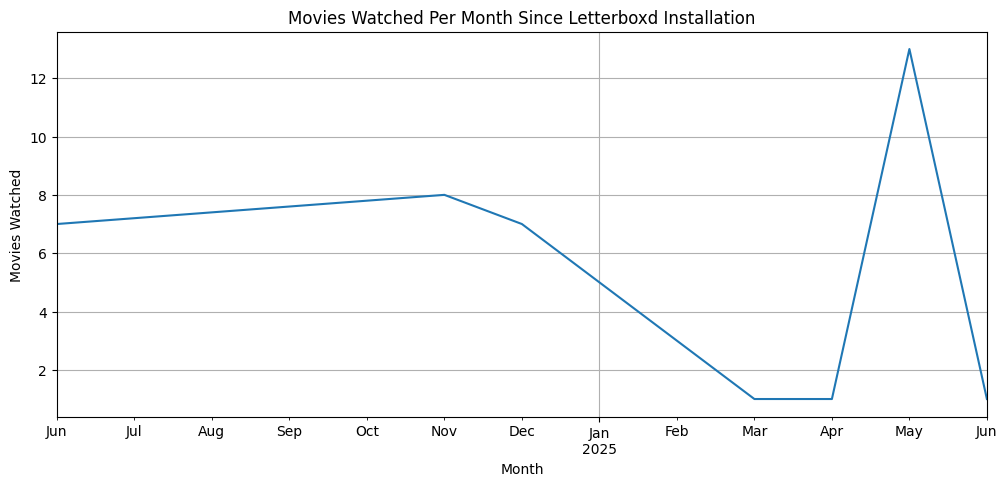

In [436]:
import matplotlib.pyplot as plt

movies_per_month = diary.groupby('Month').size()

movies_per_month.plot(kind='line', figsize=(12, 5), title='Movies Watched Per Month Since Letterboxd Installation')
plt.xlabel('Month')
plt.ylabel('Movies Watched')
plt.grid(True)
plt.show()


Here we have my film watching habits by month, since I downloaded Letterboxd. We can see the summer spike, the college lull, and others!

###🎭 Top Genres Watched

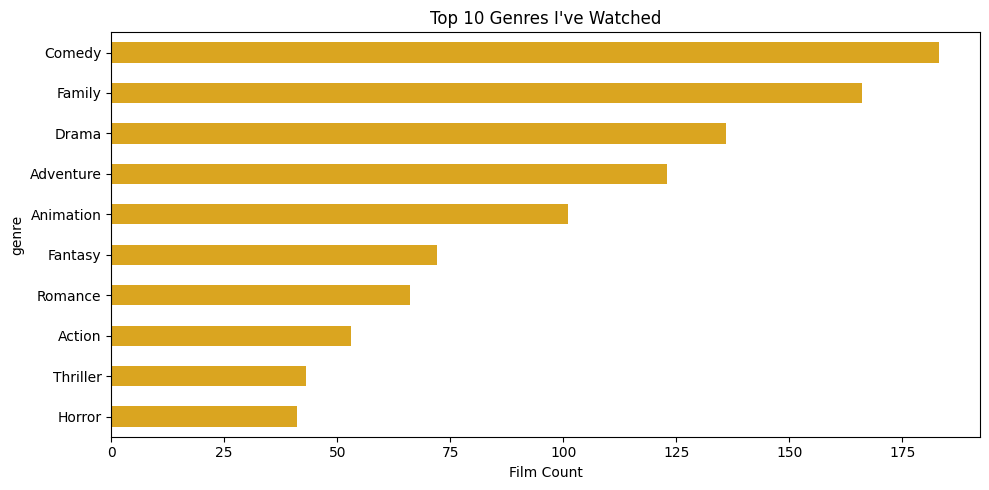

In [388]:
df = duckdb.sql("""
    SELECT genre, COUNT(*) AS count
    FROM all_seen, UNNEST(genres) AS t(genre)
    GROUP BY genre
    ORDER BY count DESC
    LIMIT 10
""").df()

df.plot.barh(x='genre', y='count', color='goldenrod', figsize=(10, 5), legend=False)
plt.title("Top 10 Genres I've Watched")
plt.xlabel("Film Count")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


This visualization highlights the film genres I keep coming back to, from late-night thrillers to comfort comedies. It’s my personal cinematic fingerprint, one genre-binge at a time. It also documents what I've historically watched, which is why comedy and family makes so much sense!

In [389]:
duckdb.sql("""
    SELECT genre, COUNT(*) AS total
    FROM all_seen,
    UNNEST(genres) AS t(genre)
    GROUP BY genre
    ORDER BY total DESC
""").df()


,genre,total
0,Comedy,183
1,Family,166
2,Drama,136
3,Adventure,123
4,Animation,101
5,Fantasy,72
6,Romance,66
7,Action,53
8,Thriller,43
9,Horror,41


###🎬 Most Watched Directors

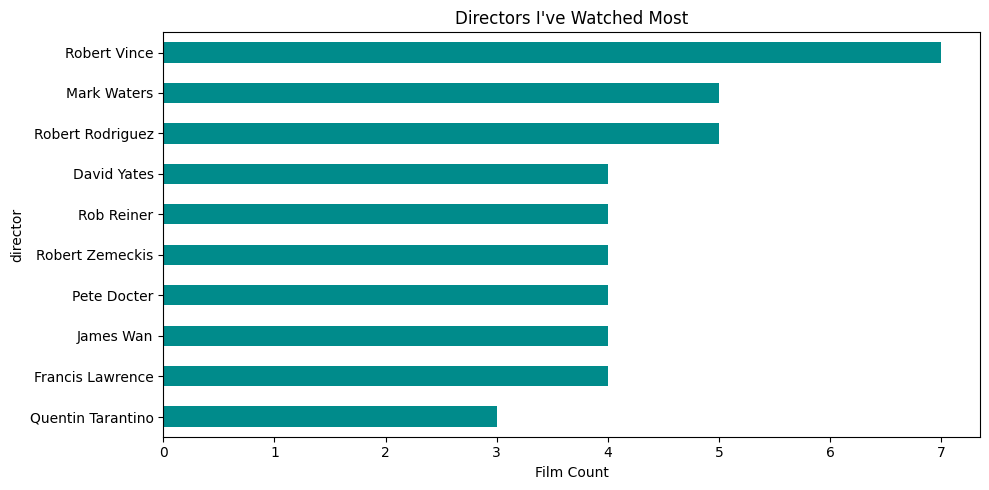

In [394]:
df = duckdb.sql("""
    SELECT director, COUNT(*) AS films
    FROM all_seen
    WHERE director IS NOT NULL
    GROUP BY director
    ORDER BY films DESC
    LIMIT 10
""").df()

df.plot.barh(x='director', y='films', color='darkcyan', figsize=(10, 5), legend=False)
plt.title("Directors I've Watched Most")
plt.xlabel("Film Count")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Whether it’s the signature style, a long filmography, or just pure genius—I tend to gravitate toward certain filmmakers more than others. These are the names that pop up in my watch history most often. It's crazy because I can have a FAVORITE movie with a certain director, but they won't pup up on this graph. These are the consistent players in my opinion-Or they just have LOTS of films!

In [390]:
duckdb.sql("""
    SELECT director, COUNT(*) AS total_watched
    FROM all_seen
    WHERE director IS NOT NULL
    GROUP BY director
    ORDER BY total_watched DESC
    LIMIT 10
""").df()


,director,total_watched
0,Robert Vince,7
1,Mark Waters,5
2,Robert Rodriguez,5
3,Rob Reiner,4
4,David Yates,4
5,Robert Zemeckis,4
6,Pete Docter,4
7,James Wan,4
8,Francis Lawrence,4
9,Quentin Tarantino,3


###🌟 Highest Rated Genres

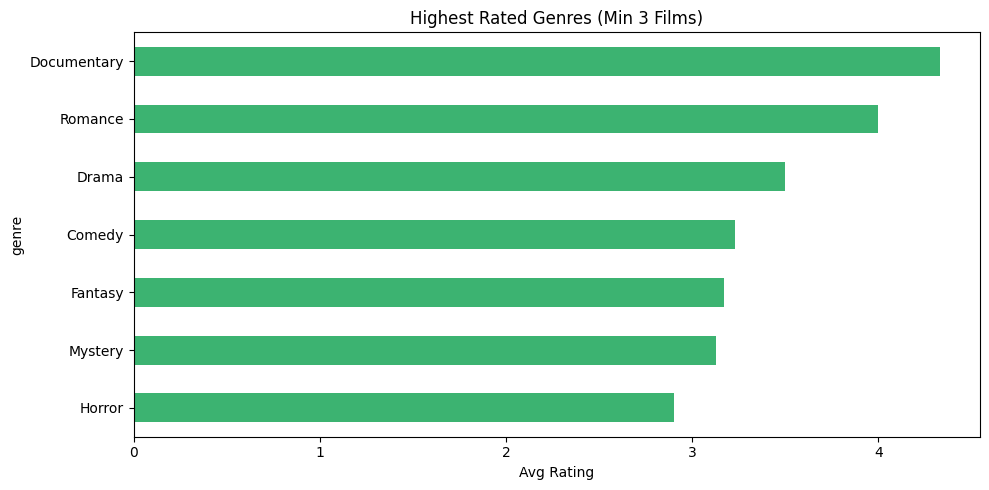

In [391]:
df = duckdb.sql("""
    SELECT genre, ROUND(AVG(Rating), 2) AS avg_rating, COUNT(*) AS count
    FROM all_seen, UNNEST(genres) AS t(genre)
    WHERE Rating IS NOT NULL
    GROUP BY genre
    HAVING COUNT(*) >= 3
    ORDER BY avg_rating DESC
    LIMIT 10
""").df()

df.plot.barh(x='genre', y='avg_rating', color='mediumseagreen', figsize=(10, 5), legend=False)
plt.title("Highest Rated Genres (Min 3 Films)")
plt.xlabel("Avg Rating")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


This one’s based on my personal ratings—where my tastes and the genre align best. These are the categories that not only draw me in but also leave me satisfied enough to hit 4 stars or higher. Makes a lot of sense. Documentary films can be absolutely fantastic, it's hard to not give them so many stars!

In [392]:
duckdb.sql("""
    SELECT
      genre,
      ROUND(AVG(Rating), 2) AS avg_rating,
      COUNT(*) AS count
    FROM all_seen,
    UNNEST(genres) AS t(genre)
    WHERE Rating IS NOT NULL
    GROUP BY genre
    HAVING COUNT(*) >= 3
    ORDER BY avg_rating DESC
""").df()


,genre,avg_rating,count
0,Documentary,4.33,3
1,Romance,4.00,6
2,Drama,3.50,16
3,Comedy,3.23,11
4,Fantasy,3.17,3
5,Mystery,3.13,4
6,Horror,2.90,5


###🌟 Highest Rated Directors

In [393]:
duckdb.sql("""
    SELECT
      director,
      ROUND(AVG(Rating), 2) AS avg_rating
    FROM all_seen
    WHERE director IS NOT NULL AND Rating IS NOT NULL
    GROUP BY director
    ORDER BY avg_rating DESC
""").df()


,director,avg_rating
0,Robert Zemeckis,5.0
1,Jon M. Chu,5.0
2,Luca Rea,5.0
3,Daniel Hoesl,5.0
4,Emerald Fennell,4.0
5,Jay-Lewis Mitchell,4.0
6,Jessica Graham,4.0
7,Sean Baker,4.0
8,Ari Aster,4.0
9,Amber Sealey,3.5


Based on my ratings, these filmmakers have the strongest track record. Fewer watches, maybe—but when I do, I love them. Pure quality over quantity.

###🗺️ World Map of Film Origins

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127871 (\N{POPCORN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


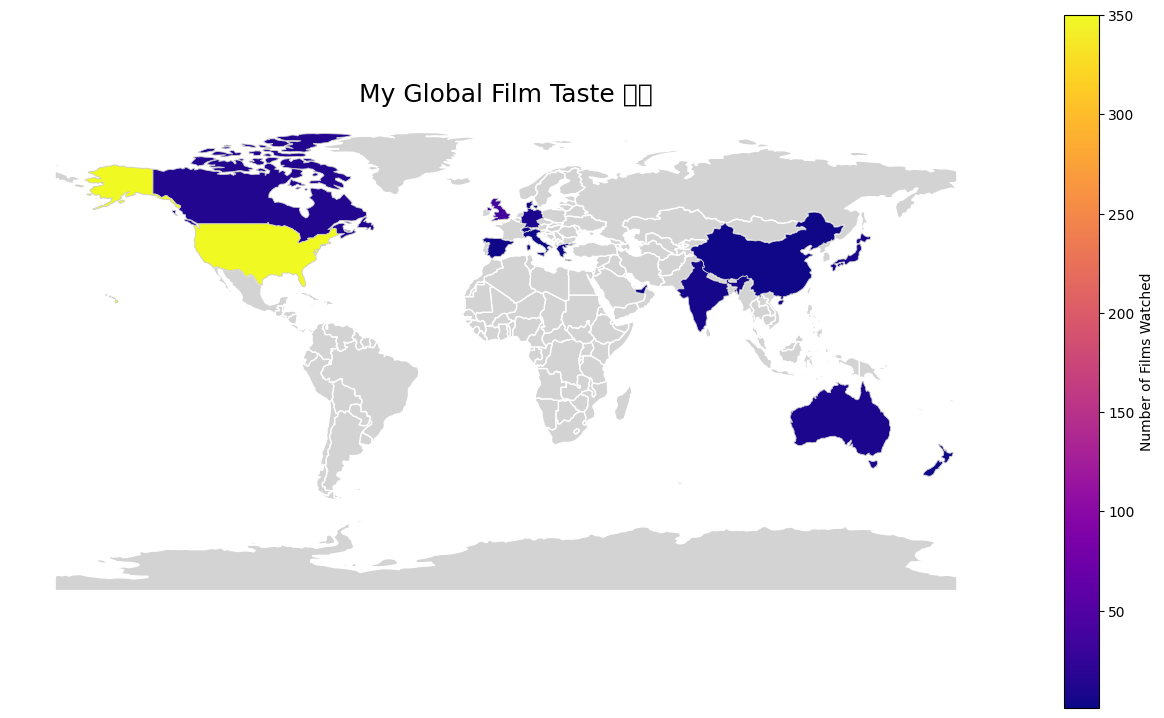

In [379]:
fig, ax = plt.subplots(figsize=(16, 9))
world.plot(ax=ax, color='lightgrey', edgecolor='white')  # base layer
world_merged.dropna(subset=['count']).plot(
    column='count',
    cmap='plasma',
    linewidth=0.6,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Number of Films Watched"},
)
plt.title("My Global Film Taste 🌍🍿", fontsize=18)
plt.axis('off')
plt.show()


From Hollywood to Hong Kong, this map shows where the films I’ve watched come from. It’s a visual snapshot of my international viewing habits—and maybe a reminder to branch out even more.

In [380]:
top_countries = country_counts.sort_values(by='count', ascending=False).head(10)
top_countries


,iso_a3,count
0,USA,350
1,GBR,38
2,CAN,12
3,DEU,10
4,AUS,9
5,JPN,7
6,IND,6
7,FRA,5
8,ESP,3
9,CHN,3


###📈 Ratings

These charts dive into how I rate films overall. Am I generous? Harsh? Dangerously neutral? Here’s the breakdown of how I’ve scored what I’ve seen—plus how my ratings have evolved over time.

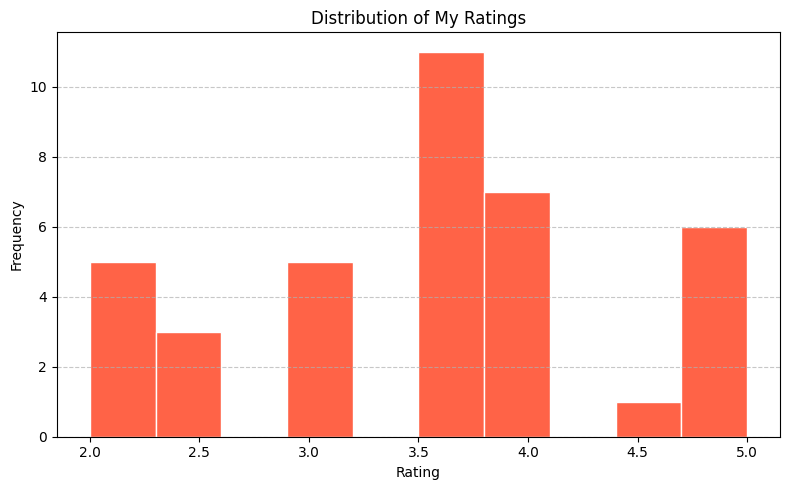

In [381]:
df = all_seen.dropna(subset=['Rating'])

plt.figure(figsize=(8, 5))
plt.hist(df['Rating'], bins=10, color='tomato', edgecolor='white')
plt.title("Distribution of My Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


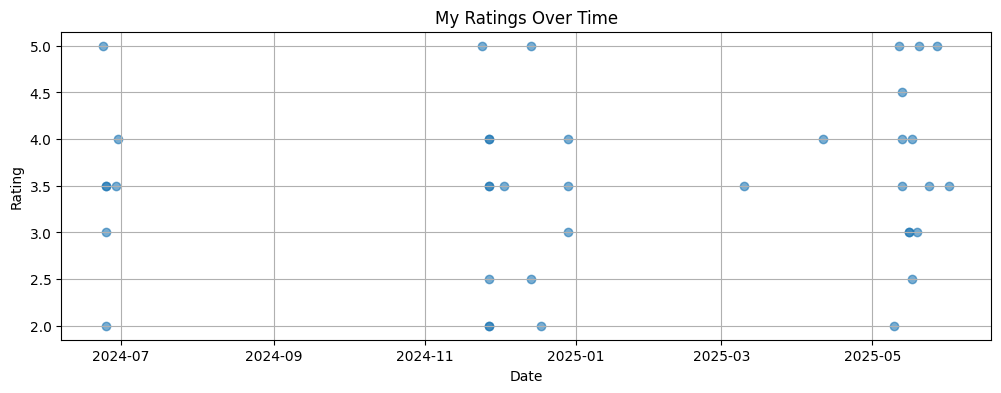

In [437]:
plt.figure(figsize=(12, 4))
plt.scatter(diary['Date'], diary['Rating'], alpha=0.6)
plt.title('My Ratings Over Time')
plt.xlabel('Date')
plt.ylabel('Rating')
plt.grid(True)
plt.show()


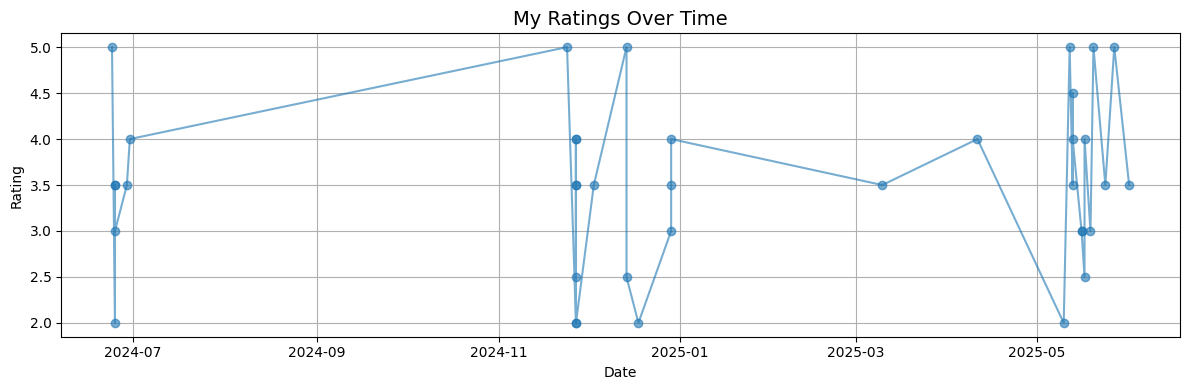

In [383]:
import matplotlib.pyplot as plt

df = all_seen.dropna(subset=['Date', 'Rating']).sort_values('Date')

plt.figure(figsize=(12, 4))
plt.plot(df['Date'], df['Rating'], marker='o', linestyle='-', alpha=0.6)
plt.title("My Ratings Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Rating")
plt.grid(True)
plt.tight_layout()
plt.show()


###🌟 Unique Stats

In [395]:
duckdb.sql("""
    SELECT
      director,
      Rating AS first_rating,
      Name AS movie
    FROM all_seen
    WHERE director IS NOT NULL AND Rating >= 4
    GROUP BY director, Rating, Name
    ORDER BY Rating DESC
""").df()


,director,first_rating,movie
0,Robert Zemeckis,5.0,Forrest Gump
1,Jon M. Chu,5.0,Wicked
2,Daniel Hoesl,5.0,Casino
3,Luca Rea,5.0,Django Unchained
4,Emerald Fennell,4.0,Saltburn
5,Jessica Graham,4.0,Waves
6,Ari Aster,4.0,Hereditary
7,Jay-Lewis Mitchell,4.0,Misery
8,Sean Baker,4.0,Anora


These are the little quirks in my data that don’t fit neatly into a chart. Directors I’ve only rated once—but highly. Standout films. Hidden patterns. It’s the storytelling side of the stats. I like this chart because it's a random assortment of films, but definitely some pivotal moments and movies. For example, Waves literally changed my life, and Saltburn is so different, so it's interesting how they also stood out in the data.

